# Solving for droplet's geometry for a given force and height

<img src="Force_angle_only.png" style="width:400px">


This code demonstrates how solve for a droplet's geometry of known volume $V$ and height $h$ and subjected to some pulling force $F$. $2a$ is the size. Instructions on setting up python on your computer can be found in https://swcarpentry.github.io/2013-08-23-harvard/.

Libraries required:
1. numpy
2. matplotlib
3. scipy
4. seaborn



## Set up jupyter notebook

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import odeint
from scipy.optimize import newton, fsolve
from scipy.integrate import simps


## Solving non-dimensionalized Laplace equation

Following the approach of Butt et al, Curr. Opin. Colloid Interface Sci. 19, 343-354 (2014), we non-dimensionalize the variables by $a$ and $\gamma$, i.e.

\begin{align}
\hat{F} &=  F \gamma^{-1} a^{-1} \\
\hat{r} &=  r a^{-1} \\
\hat{V} &=  V a^{-3} \\
\Delta \hat{P} &=  \Delta P a \gamma^{-1},\mathrm{etc}
\end{align}

and hence, we get the non-dimensionalized Young-Laplace equation

\begin{align}
\frac{\hat{u}''}{(1+\hat{u}'^{2})^{3/2}} - \frac{1}{\hat{u}\sqrt{1 + \hat{u}'^{2}}}
&= -\Delta \hat{P} \; \mathrm{for} \; \hat{z} \in (0, \hat{h}) \\
\end{align}

subject to the boundary conditions

\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}(\hat{h}) &= 1 \\
\int_{0}^{h} \pi \hat{u}^{2}d\hat{z} &= \hat{V} \\
\end{align}

and 

\begin{align}
F &= -\frac{2 \pi \hat{r}}{\sqrt{1 + \hat{u}'(0)^{2}}} + \pi r^{2}\Delta P.  
\end{align}

Using the shooting method, we chose to frame the Young-Laplace equation as an initial value problem, with initial values

\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}'(0) &= -\cot \theta,
\end{align}

while requiring that

$$\mathbf{\hat{m}}(\hat{r}, \Delta \hat{P}, \theta) =
\begin{pmatrix} \hat{u}(\hat{h})- 1 \\ 
\int_{0}^{\hat{h}} \pi \hat{u}^{2}d\hat{z} - \hat{V}\\
\hat{F} + 2 \pi \gamma \hat{r} \sin \theta - \pi \hat{r}^{2}\Delta \hat{P}
 \end{pmatrix} = 0$$.

This converts the boundary value problem into a root-finding problem of $\mathbf{\hat{m}}=0$, as implemented below



In [2]:
n_point = 100  # number of points to plot droplet profile

def ode(u, z):
    return np.array([u[1], (1+u[1]**2)**(1.5)*(1/(u[0]*np.sqrt(1+u[1]**2)) - u[2]), 0])  

# Calculate the residue 
def m_res(x, h_f, F_exp):
    
    r = x[0]
    dP = x[1]
    theta = x[2]
    
    z_arr = np.linspace(0, h_f, n_point)

    y_start = np.array([r, -1/np.tan(theta), dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-10)
    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    u_arr_1 = u_arr[dP_arr == dP]
    z_arr_1 = z_arr[dP_arr == dP]
    V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    
    u_h = u_arr[-1]
    
    
    F = 2*np.pi*r*np.sin(theta) - dP*np.pi*r**2
    return np.array([1-u_h, V_norm-V_int, F-F_exp])
        
    
def calculate_sol(x, hf):
    r = x[0]
    dP = x[1]
    theta = x[2]
    
    z_arr = np.linspace(0, hf, n_point)

    y_start = np.array([r, -1/np.tan(theta), dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-10)
    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    u_arr_1 = u_arr[dP_arr == dP]
    z_arr_1 = z_arr[dP_arr == dP]
    V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    
    F_sol = 2*np.pi*r*np.sin(theta) - dP*np.pi*r**2
    
    return z_arr, u_arr, dP, V_int, F_sol

# Results

For droplet of height $h$ = 45 $\mu$m, subjected to a pulling force $F$ = 683 nN

In [3]:
# Droplet parameters
H = 44.9989462 # Droplet height in um
F = -683.07264 # Force in nN

V = 50. # Droplet volume in pl
a = 14. # Contact size in um
gamma = 70.# Surface tension in mN/m

# Non-dimensionalized parameters
V_norm = V/a**3*1e3
H_norm = H/a
F_norm = -F/(a*gamma)

# guess values (non-dimensionalized)
dP = 1.0                       
r0 = 0.3
t0 = 140./180*np.pi

x_guess = np.array([r0, dP, t0])

# root-finding solver, look for solution m=0
x_opt = fsolve(m_res, x_guess, args=(H_norm, F_norm))
print m_res(x_opt, H_norm, F_norm)

[  1.92686977e-11   1.79755943e-09   2.51516030e-10]


Contact size is 9.5 um
Contact angle is 148.4 deg
Pressure inside droplet is 5.8 kPa


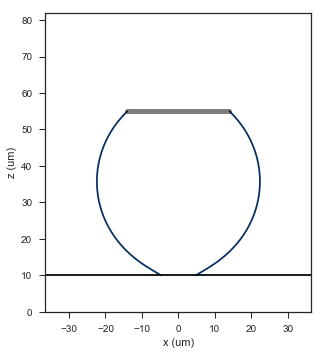

In [4]:
sns.set_style("ticks")
color_b = sns.xkcd_rgb["marine"]

z_sol, u_sol, p_sol, V_sol, F_sol = calculate_sol(x_opt, H_norm)

z_shift = 10 # shifting the base by 10 um

plt.plot(u_sol*a, z_sol*a+z_shift, color=color_b)
plt.plot(-u_sol*a, z_sol*a+z_shift, color=color_b)

plt.plot([-40, 40], [z_shift, z_shift], '-k') # plotting the base
plt.plot([-u_sol[-1]*a, u_sol[-1]*a], [H+z_shift, H+z_shift], '-k', alpha=0.5, lw=5)

plt.xlim([-73./2, 73./2])
plt.ylim([0,82])
plt.xlabel("x (um)")
plt.ylabel("z (um)")

plt.axes().set_aspect('equal')


#print out the fitted results
r_fit = x_opt[0]
P_fit = x_opt[1]
t_fit = x_opt[2]

print "Contact size is %s um" %(np.round(2*r_fit*a,1))
print "Contact angle is %s deg" %(np.round(t_fit/np.pi*180,1))
print "Pressure inside droplet is %s kPa" %(np.round(P_fit*gamma/a,1))

For droplet of height $h$ = 36 $\mu$m, subjected to a pulling force $F$ = 150 nN

In [5]:
# Droplet parameters
H = 36 # Droplet height in um
F = -150 # Force in nN

V = 50. # Droplet volume in pl
a = 14. # Contact size in um
gamma = 70.# Surface tension in mN/m

# Non-dimensionalized parameters
V_norm = V/a**3*1e3
H_norm = H/a
F_norm = -F/(a*gamma)

# guess values (non-dimensionalized)
dP = 1.0                       
r0 = 0.3
t0 = 140./180*np.pi

x_guess = np.array([r0, dP, t0])

# root-finding solver, look for solution m=0
x_opt = fsolve(m_res, x_guess, args=(H_norm, F_norm))
print m_res(x_opt, H_norm, F_norm)

[ -5.41329204e-11   1.61772817e-10   1.23185739e-10]


Contact size is 33.1 um
Contact angle is 134.2 deg
Pressure inside droplet is 5.9 kPa


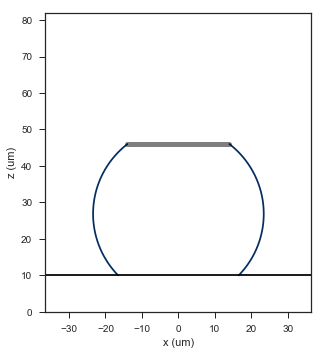

In [6]:
z_sol, u_sol, p_sol, V_sol, F_sol = calculate_sol(x_opt, H_norm)

z_shift = 10 # shifting the base by 10 um

plt.plot(u_sol*a, z_sol*a+z_shift, color=color_b)
plt.plot(-u_sol*a, z_sol*a+z_shift, color=color_b)

plt.plot([-40, 40], [z_shift, z_shift], '-k') # plotting the base
plt.plot([-u_sol[-1]*a, u_sol[-1]*a], [H+z_shift, H+z_shift], '-k', alpha=0.5, lw=5)

plt.xlim([-73./2, 73./2])
plt.ylim([0,82])
plt.xlabel("x (um)")
plt.ylabel("z (um)")

plt.axes().set_aspect('equal')


#print out the fitted results
r_fit = x_opt[0]
P_fit = x_opt[1]
t_fit = x_opt[2]

print "Contact size is %s um" %(np.round(2*r_fit*a,1))
print "Contact angle is %s deg" %(np.round(t_fit/np.pi*180,1))
print "Pressure inside droplet is %s kPa" %(np.round(P_fit*gamma/a,1))